In [9]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from data_loader import load_dataset
import numpy as np

#DATASET
X, y =  load_dataset()

X.shape (1000, 480, 640)


In [10]:
mask = ((y > 0.45) & (y < 0.55)) | (y < 0.05) | (y > 0.95)
X = X[mask]
y = y[mask]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [12]:
#NETWORK
model = Sequential()
model.add(Conv2D(input_shape=(480,640,1), filters=32, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=16, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(filters=16, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(filters=16, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=16, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(filters=16, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(filters=16, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=8, activation="relu"))
model.add(Dense(units=4, activation="relu"))
model.add(Dense(units=1, activation="sigmoid"))


def loss_funtion(real_eps, eps_new):
    x = tf.abs(real_eps - eps_new)
    return tf.math.minimum(x, 1-x)


def my_metric_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

compare=loss_funtion(np.array([0,1,0.5, 0.25]), np.array([1,0.75, 1, 0.5]))
print(compare.numpy(), "should be: [0.   0.25 0.5  0.25]")

#COMPILATION
model.compile(optimizer='adam', loss=loss_funtion, metrics=[tf.metrics.MeanSquaredError()])
model.summary()



[0.   0.25 0.5  0.25] should be: [0.   0.25 0.5  0.25]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 478, 638, 32)      320       
                                                                 
 conv2d_21 (Conv2D)          (None, 476, 636, 32)      9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 238, 318, 32)     0         
 g2D)                                                            
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 119, 159, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 117, 157, 32)      9248      
                                                                 

In [13]:
#TRAIN THE MODEL
hist = model.fit(X_train, y_train, epochs=5, batch_size = 16)

Epoch 1/5
10/10 [==============================] - 39s 4s/step - loss: 0.2253 - mean_squared_error: 0.1510
Epoch 2/5
10/10 [==============================] - 39s 4s/step - loss: 0.0541 - mean_squared_error: 0.2358
Epoch 3/5
10/10 [==============================] - 35s 4s/step - loss: 0.0260 - mean_squared_error: 0.2511
Epoch 4/5
10/10 [==============================] - 33s 3s/step - loss: 0.0316 - mean_squared_error: 0.2488
Epoch 5/5
10/10 [==============================] - 36s 4s/step - loss: 0.0343 - mean_squared_error: 0.2562


In [14]:
y_pred = model.predict(X_test)

2/2 [==============================] - 2s 409ms/step


In [15]:
x = np.abs(y_pred.squeeze() - y_test)
results = np.min([x,1-x], axis=0)
print(np.average(results))

0.020822608566284196


True epsilon:0.985 Predicted:[0.9999999]


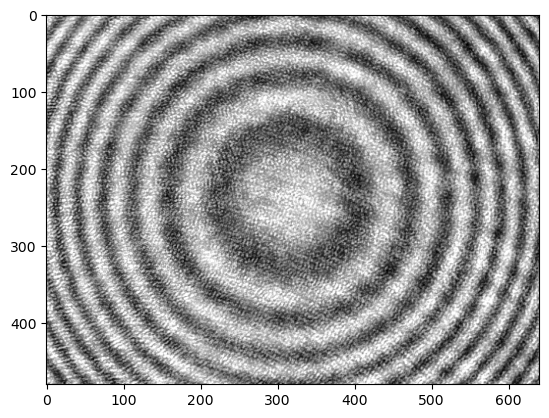

True epsilon:0.508 Predicted:[0.49902654]


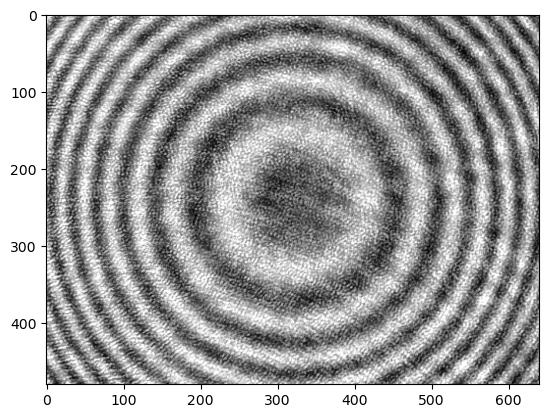

True epsilon:0.531 Predicted:[0.49902654]


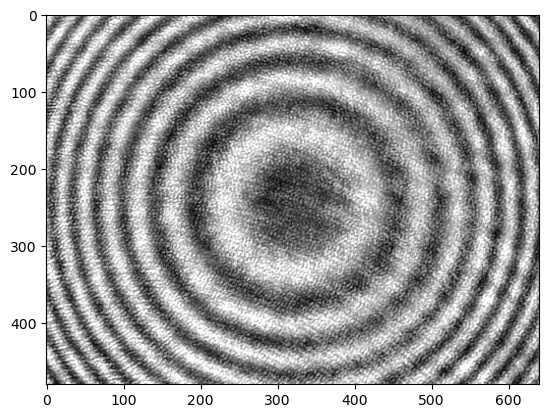

True epsilon:0.492 Predicted:[0.49902654]


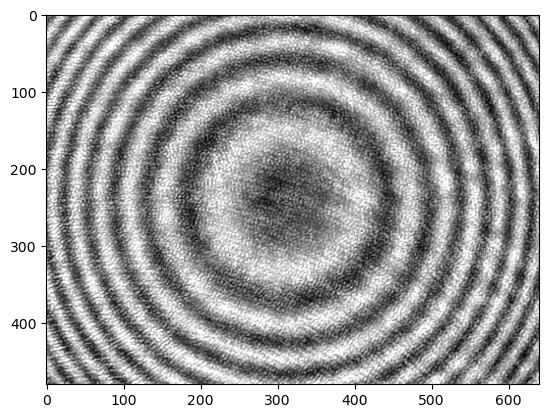

True epsilon:0.032 Predicted:[0.9999997]


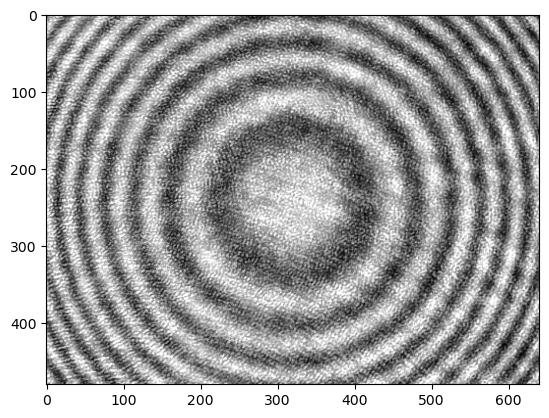

In [23]:
import matplotlib.pyplot as plt

for i, x in enumerate(X_test[:5]):
    print(f"True epsilon:{y_test[i]} Predicted:{y_pred[i]}")
    plt.imshow(x, cmap="gray")
    plt.show()